In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
# Start Spark Session
try:
    spark = SparkSession.builder.appName("CrimeDataProcessing").getOrCreate()
except Exception as e:
    print(f"Error initializing Spark session: {e}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/17 12:10:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# read the data
file_path = "/Users/daisyoung/Downloads/Crime_Data_from_2020_to_Present.csv"

df = spark.read.option("header", "true").csv(file_path, inferSchema = True)
df.show()

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+-----

24/10/17 12:10:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# check the data types of the columns
df.printSchema()

root
 |-- DR_NO: integer (nullable = true)
 |-- Date Rptd: string (nullable = true)
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Rpt Dist No: integer (nullable = true)
 |-- Part 1-2: integer (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- Crm Cd 1: integer (nullable = true)
 |-- Crm Cd 2: integer (nullable = true)
 |-- Crm Cd 3: integer (nullable = true)
 |-- Crm Cd 4: integer (nullable = true)
 |-- L

In [6]:
print(f"There are {df.count()} rows in the raw dataset.")

There are 970760 rows in the raw dataset.


In [7]:
# data cleaning
class DataCleaning:
    def __init__(self, data) -> None:
        self.data = data
        
    def drop_duplicates(self):
        # drop duplicates
        duplicate_count = self.data.count() - self.data.dropDuplicates().count()
        print(f"Number of duplicate rows: {duplicate_count}")

    def check_missing_value(self):
        # Check for missing values in crime data
        self.missing_values = self.data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in self.data.columns])
        return self.missing_values
        
    def handle_missing_values(self):
        # replace the values ​​below 1 for the "Vict Age" column with NaN
        self.data = self.data.withColumn("Vict Age", F.when(F.col("Vict Age") < 1, None).otherwise(F.col("Vict Age")))
        
        # fill missing values in 'Vict Sex' with 'X'
        self.data = self.data.fillna({'Vict Sex': 'X'})
        
        # fill missing values in categorical columns with a string such as "N/A"
        categorical_cols = [c for c in self.data.columns if dict(self.data.dtypes)[c] == 'object']
        
        for column in categorical_cols:
            if self.data.filter(F.col(column).isNull()).count() > 0:
                self.data = self.data.withColumn(column, F.when(F.col(column).isNull(), 'N/A').otherwise(F.col(column)))

        # delete rows with empty 'Crm Cd', 'Status' or empty detailed location
        self.data.na.drop(subset = ['Crm Cd', 'Status', 'LAT', 'LON'])

        return self.data

In [8]:
dc = DataCleaning(df)
dc.drop_duplicates()
missing_values = dc.check_missing_value()
missing_values.show()

24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/17 12:10:46 WARN RowBasedKeyValueBatch: Calling spill() on

Number of duplicate rows: 0


+-----+---------+--------+--------+----+---------+-----------+--------+------+-----------+-------+--------+--------+------------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+--------+------------+---+---+
|DR_NO|Date Rptd|DATE OCC|TIME OCC|AREA|AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|Crm Cd Desc|Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc|Weapon Used Cd|Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|LOCATION|Cross Street|LAT|LON|
+-----+---------+--------+--------+----+---------+-----------+--------+------+-----------+-------+--------+--------+------------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+--------+------------+---+---+
|    0|        0|       0|       0|   0|        0|          0|       0|     0|          0| 141520|       0|  134812|      134822|       14|        583|        645153|     645153|     1|          0|      11|  

In [9]:
df = dc.handle_missing_values()
# check again after handling missing values
missing_values = dc.check_missing_value()
missing_values.show()

+-----+---------+--------+--------+----+---------+-----------+--------+------+-----------+-------+--------+--------+------------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+--------+------------+---+---+
|DR_NO|Date Rptd|DATE OCC|TIME OCC|AREA|AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|Crm Cd Desc|Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc|Weapon Used Cd|Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|LOCATION|Cross Street|LAT|LON|
+-----+---------+--------+--------+----+---------+-----------+--------+------+-----------+-------+--------+--------+------------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+--------+------------+---+---+
|    0|        0|       0|       0|   0|        0|          0|       0|     0|          0| 141520|  253597|       0|      134822|       14|        583|        645153|     645153|     1|          0|      11|  

In [10]:
class FeatureEngineering:
    def __init__(self, data):
        self.data = data

    def feature_selection(self):
        # delete columns with redundant information
        self.data = self.data.drop('Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street')
        return self.data

    def convert_datetime(self):
        # convert 'Date Rptd' and 'DATE OCC' into datetime
        self.data = self.data.withColumn("Date Rptd", F.to_date(F.col("Date Rptd"), "MM/dd/yyyy hh:mm:ss a"))
        self.data = self.data.withColumn("DATE OCC", F.to_date(F.col("DATE OCC"), "MM/dd/yyyy hh:mm:ss a"))

        # convert 'TIME OCC' into TimeType
        self.data = self.data.withColumn("TIME OCC", F.lpad(F.col("TIME OCC").cast("string"), 4, '0'))  # Pad with zeros to ensure length of 4
        self.data = self.data.withColumn("TIME OCC", F.concat(F.substring("TIME OCC", 1, 2), F.lit(':'), F.substring("TIME OCC", 3, 2)))  # Format as HH:mm

        # extract year, month and day of the week from datetime
        self.data = self.data.withColumn('Year OCC', F.year("DATE OCC"))
        self.data = self.data.withColumn('Month OCC', F.month("DATE OCC"))
        self.data = self.data.withColumn('Day OCC', F.date_format(F.col("DATE OCC"), "EEEE"))

        return self.data
    
    def crm_cd_mapping(self, file_path):
        # Merge the original data with category data
        self.code2category = spark.read.option("header", "true").csv(file_path, inferSchema = True).select("Crm Cd", "Category")
        self.data = self.data.join(self.code2category, on = 'Crm Cd')
        return self.data
    
    def vict_cd_transform(self):
        # Mapping of victim codes to descriptions
        self.data = self.data.withColumn(
            "Vict Descent",
            F.when(F.col("Vict Descent") == "A", "Other Asian")
            .when(F.col("Vict Descent") == "B", "Black")
            .when(F.col("Vict Descent") == "C", "Chinese")
            .when(F.col("Vict Descent") == "D", "Cambodian")
            .when(F.col("Vict Descent") == "F", "Filipino")
            .when(F.col("Vict Descent") == "G", "Guamanian")
            .when(F.col("Vict Descent") == "H", "Hispanic/Latin/Mexican")
            .when(F.col("Vict Descent") == "I", "American Indian/Alaskan Native")
            .when(F.col("Vict Descent") == "J", "Japanese")
            .when(F.col("Vict Descent") == "K", "Korean")
            .when(F.col("Vict Descent") == "L", "Laotian")
            .when(F.col("Vict Descent") == "O", "Other")
            .when(F.col("Vict Descent") == "P", "Pacific Islander")
            .when(F.col("Vict Descent") == "S", "Samoan")
            .when(F.col("Vict Descent") == "U", "Hawaiian")
            .when(F.col("Vict Descent") == "V", "Vietnamese")
            .when(F.col("Vict Descent") == "W", "White")
            .when(F.col("Vict Descent") == "X", "Unknown")
            .when(F.col("Vict Descent") == "Z", "Asian Indian")
            .otherwise(F.col("Vict Descent")))
        return self.data
    
    def add_age_group(self):
        # Add the 'age_group' column
        self.data = self.data.withColumn("age_group", 
            F.when((F.col("Vict Age") >= 1) & (F.col("Vict Age") <= 4), "Toddler")
            .when((F.col("Vict Age") >= 5) & (F.col("Vict Age") <= 12), "Kid")
            .when((F.col("Vict Age") >= 13) & (F.col("Vict Age") <= 17), "Teenager")
            .when((F.col("Vict Age") >= 18) & (F.col("Vict Age") <= 25), "Young Adult")
            .when((F.col("Vict Age") >= 26) & (F.col("Vict Age") <= 39), "Adult")
            .when((F.col("Vict Age") >= 40) & (F.col("Vict Age") <= 65), "Middle Age")
            .otherwise("Senior"))
        return self.data

In [11]:
fe = FeatureEngineering(df)
fe.feature_selection()
fe.convert_datetime()

DataFrame[DR_NO: int, Date Rptd: date, DATE OCC: date, TIME OCC: string, AREA: int, AREA NAME: string, Rpt Dist No: int, Part 1-2: int, Crm Cd: int, Crm Cd Desc: string, Mocodes: string, Vict Age: int, Vict Sex: string, Vict Descent: string, Premis Cd: int, Premis Desc: string, Weapon Used Cd: int, Weapon Desc: string, Status: string, Status Desc: string, LOCATION: string, LAT: double, LON: double, Year OCC: int, Month OCC: int, Day OCC: string]

In [12]:
code_path = "/Users/daisyoung/Downloads/Cime_Category.csv"
fe.crm_cd_mapping(code_path)
fe.vict_cd_transform()
df = fe.add_age_group()
df.show()

+------+---------+----------+----------+--------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+------------+--------------------+-------+---------+--------+---------+---------+------------------+-----------+
|Crm Cd|    DR_NO| Date Rptd|  DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|            LOCATION|    LAT|      LON|Year OCC|Month OCC|  Day OCC|          Category|  age_group|
+------+---------+----------+----------+--------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+------------+--------------------+-------+------

In [13]:
print(f"There are {df.count()} rows in the dataset are data preprocessing.")

There are 970760 rows in the dataset are data preprocessing.


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_analysis(data):
    # use correlation matrix and heatmap for numeric data
    numeric_cols = [c for c in data.columns if dict(data.dtypes)[c] in ['int', 'double']]
    correlation_matrix = np.zeros((len(numeric_cols), len(numeric_cols)))

    # Calculate correlations between each pair of numeric columns
    for i, col1 in enumerate(numeric_cols):
        for j, col2 in enumerate(numeric_cols):
            correlation_matrix[i, j] = data.stat.corr(col1, col2)

    # Create a DataFrame for the correlation matrix for visualization
    corr_df = pd.DataFrame(correlation_matrix, index = numeric_cols, columns = numeric_cols)

    # Create a mask to hide the upper triangle
    mask = np.triu(np.ones_like(corr_df))
    
    # Plot the heatmap with the mask
    plt.figure(figsize = (12, 10))
    sns.heatmap(correlation_matrix, mask = mask, annot = True, fmt=".2f", cmap = 'coolwarm') 
    plt.title('Correlation Matrix')
    plt.show()

24/10/17 12:10:55 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


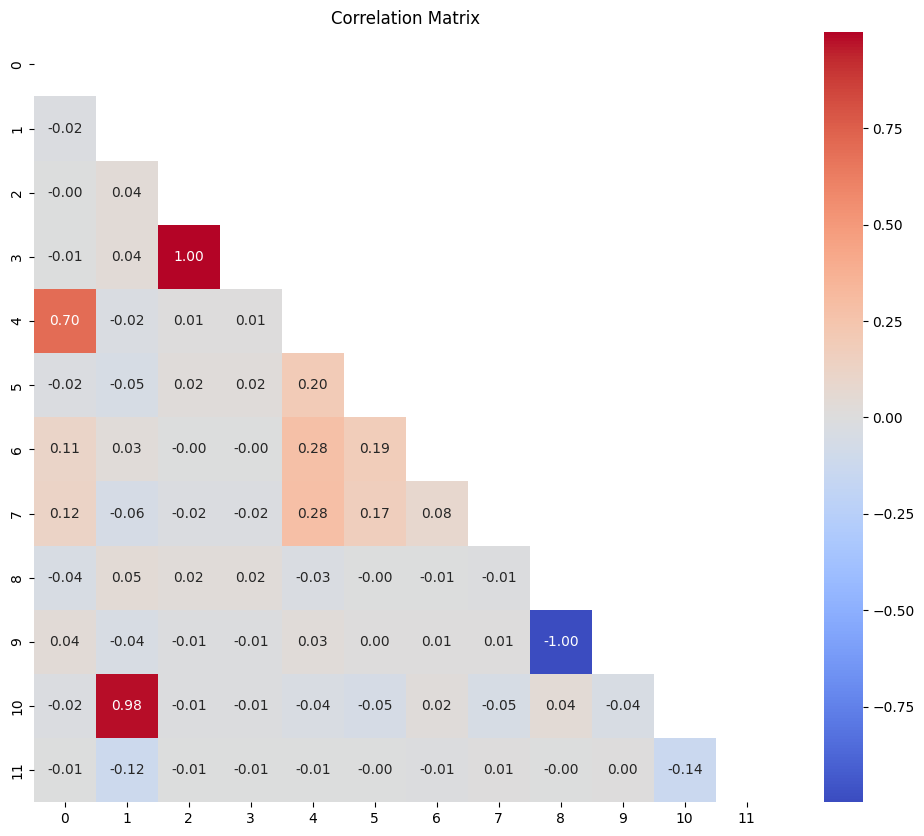

In [15]:
correlation_analysis(df)

In [16]:
# max crime occurred date
# Group by 'DATE OCC' and count the occurrences
occ_date = df.groupBy('DATE OCC').agg(F.count('DR_NO').alias('Crime Count'))

# Get the maximum number of crimes occurred on a single day
max_crimes = occ_date.agg(F.max('Crime Count')).collect()[0][0]

print(f"The max number of crimes occurred on a single day is {max_crimes}.")

The max number of crimes occurred on a single day is 1152.


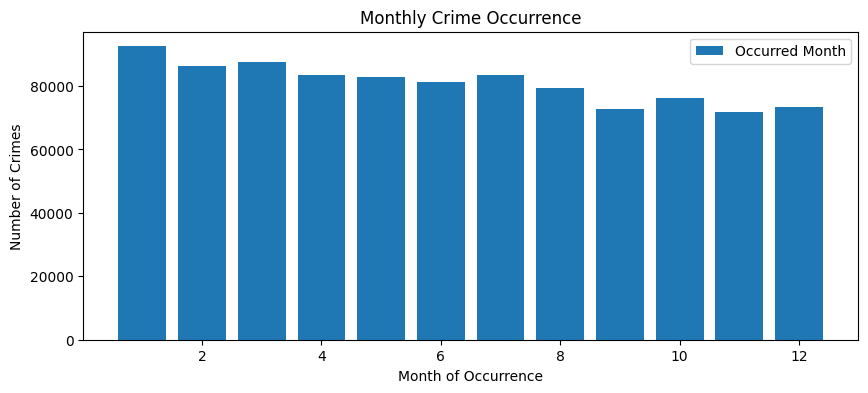

In [17]:
# crime occurance line plot on monthly basis
occ_month = df.groupBy('Month OCC').agg(F.count('DR_NO').alias('Crime Count'))

# Collect the results to the driver and convert to Pandas DataFrame
occ_month_pd = occ_month.toPandas()

# Sort the DataFrame by 'DATE OCC'
occ_month_pd.sort_values('Month OCC', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(occ_month_pd['Month OCC'], occ_month_pd['Crime Count'], label = 'Occurred Month')
ax.set_title('Monthly Crime Occurrence')
ax.set_xlabel('Month of Occurrence')
ax.set_ylabel('Number of Crimes')
ax.legend()
plt.show()

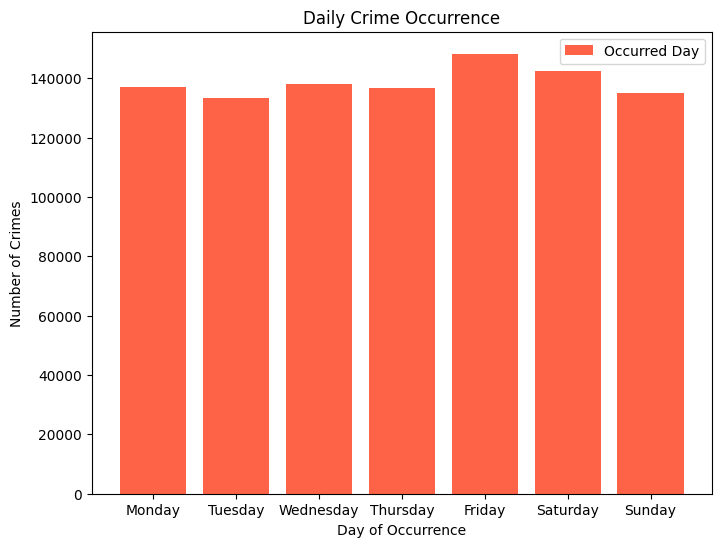

In [18]:
# crime occurance line plot on daily basis
occ_day = df.groupBy('Day OCC').agg(F.count('DR_NO').alias('Crime Count'))

# Collect the results to the driver and convert to Pandas DataFrame
occ_day_pd = occ_day.toPandas()

# Define the order of the days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'Day OCC' to a categorical type with the specified order
occ_day_pd['Day OCC'] = pd.Categorical(occ_day_pd['Day OCC'], categories=day_order, ordered=True)

# Sort the DataFrame by 'DATE OCC'
occ_day_pd.sort_values('Day OCC', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize = (8, 6))
ax.bar(occ_day_pd['Day OCC'], occ_day_pd['Crime Count'], label = 'Occurred Day', color = 'tomato')
ax.set_title('Daily Crime Occurrence')
ax.set_xlabel('Day of Occurrence')
ax.set_ylabel('Number of Crimes')
ax.legend()
plt.show()

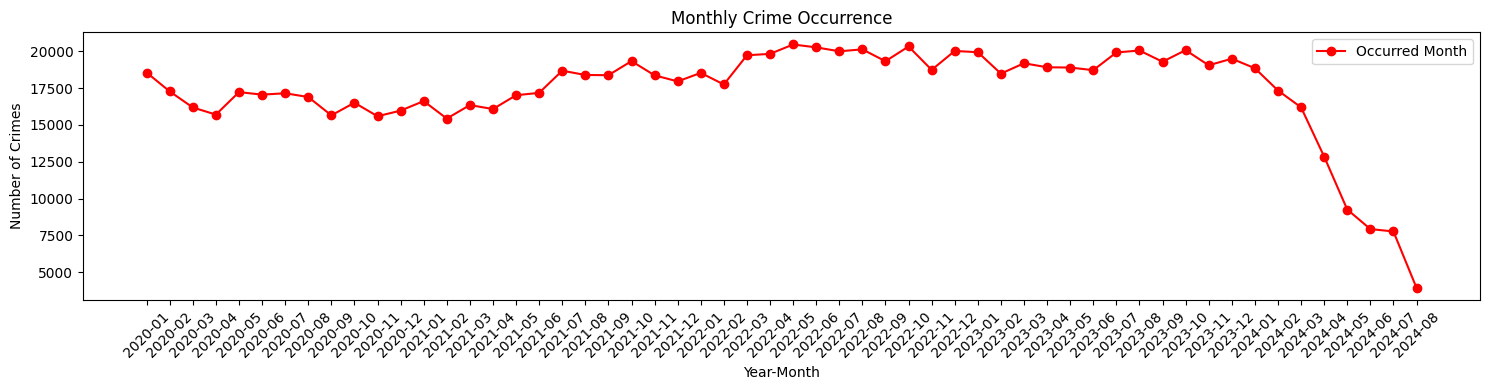

In [19]:
# Create a new column for Year-Month
df = df.withColumn('Year-Month', F.date_format('DATE OCC', 'yyyy-MM'))

# Group by 'Year-Month' and count occurrences
occ_month = df.groupBy('Year-Month').agg(F.count('DR_NO').alias('Crime Count'))

# Collect the results to the driver and convert to Pandas DataFrame
occ_month_pd = occ_month.toPandas()

# Sort the DataFrame by 'Year-Month'
occ_month_pd.sort_values('Year-Month', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(occ_month_pd['Year-Month'], occ_month_pd['Crime Count'], color='red', marker='o', label='Occurred Month')
ax.set_title('Monthly Crime Occurrence')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Number of Crimes')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

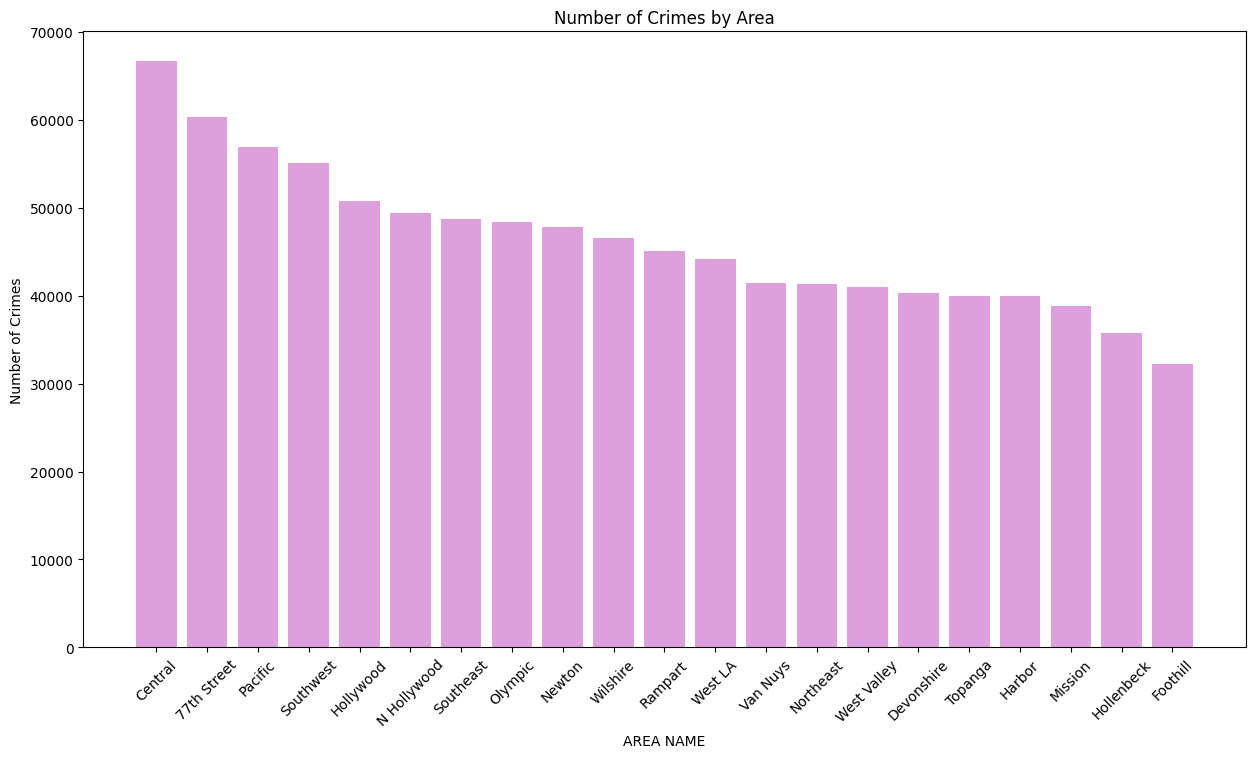

In [20]:
# crime record bar plot based on 'AREA NAME'
# Group by 'AREA NAME' and count occurrences
area_crime = df.groupBy('AREA NAME').agg(F.count('DR_NO').alias('Crime Count'))

# Collect the results to the driver and convert to Pandas DataFrame
area_crime_pd = area_crime.toPandas()

# Sort the DataFrame by crime count in descending order
area_crime_pd.sort_values(by = 'Crime Count', ascending = False, inplace = True)

# Plotting
plt.figure(figsize = (15, 8))
plt.bar(area_crime_pd['AREA NAME'], area_crime_pd['Crime Count'], color = 'plum')
plt.title('Number of Crimes by Area')
plt.xlabel('AREA NAME')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45)
plt.show()

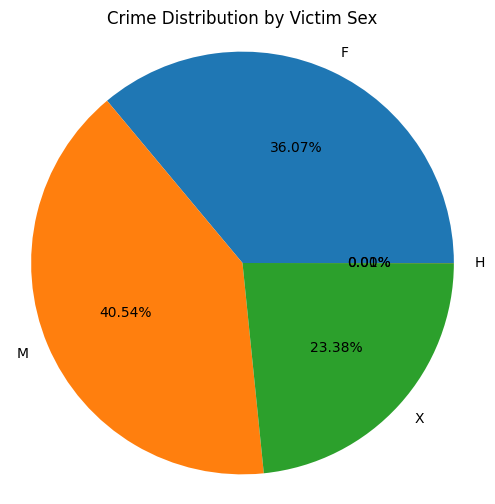

In [24]:
# Group by 'Victim_sex' and count occurrences
df_gender = df.groupBy('Vict Sex').agg(F.count('DR_NO').alias('Crime Count'))

# Collect the results to the driver and convert to Pandas DataFrame
df_gender_pd = df_gender.toPandas()

# Plotting the pie chart
plt.figure(figsize = (6, 6))
plt.pie(df_gender_pd['Crime Count'], labels = df_gender_pd['Vict Sex'], autopct = '%.2f%%')
plt.title('Crime Distribution by Victim Sex')
plt.axis('equal')
plt.show()

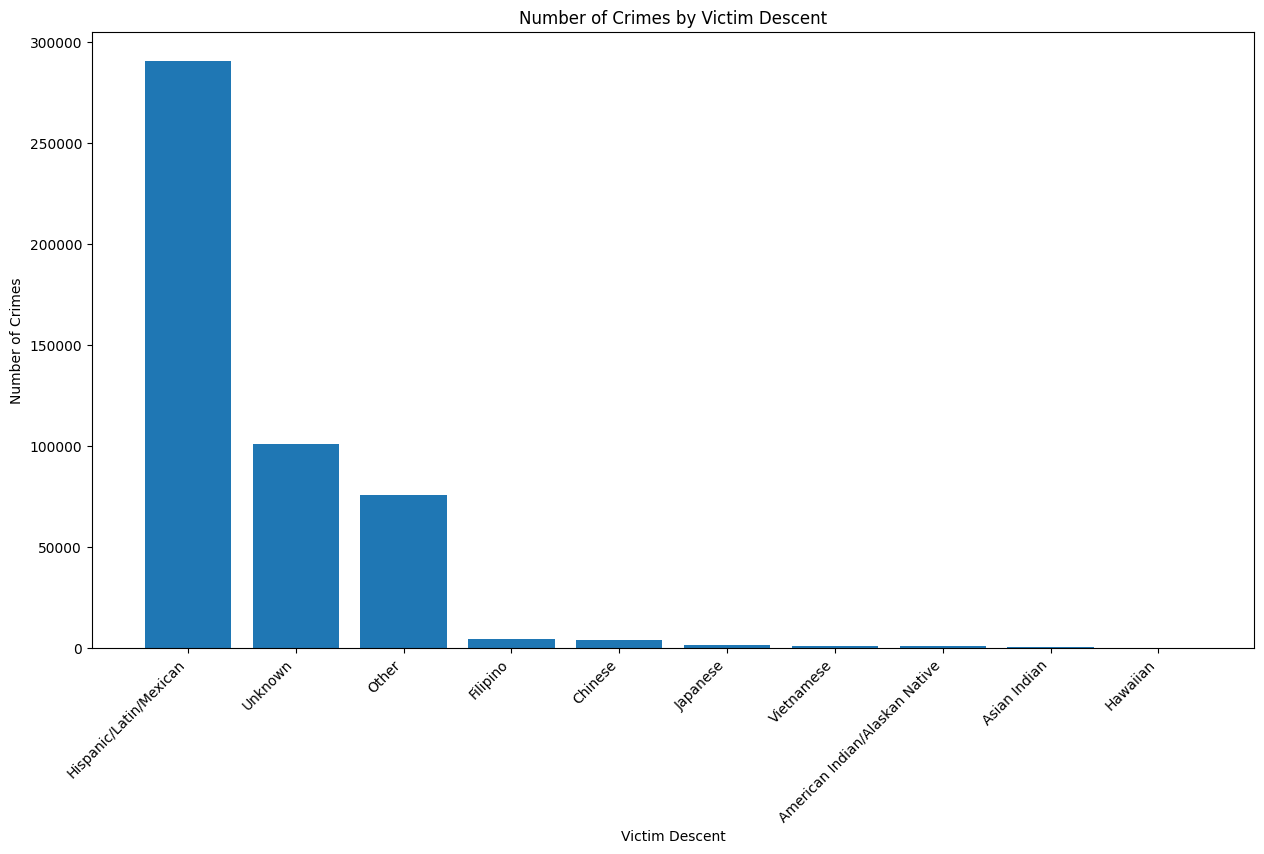

In [25]:
# Group by 'Vict Descent' and count occurrences
vict_descent = df.groupBy('Vict Descent').agg(F.count('DR_NO').alias('Crime Count')).filter(F.col('Vict Descent').isNotNull())

# Collect the results to the driver and convert to Pandas DataFrame
# Select top 10 'Vict Descent'
vict_descent_pd = vict_descent.toPandas().head(10)

# Sort the DataFrame by crime count in descending order
vict_descent_pd.sort_values(by = 'Crime Count', ascending = False, inplace = True)

# Plotting
plt.figure(figsize = (15, 8))
plt.bar(vict_descent_pd['Vict Descent'], vict_descent_pd['Crime Count'])
plt.title('Number of Crimes by Victim Descent')
plt.xlabel('Victim Descent')
plt.ylabel('Number of Crimes')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [26]:
# Split the dataset into training and test sets
train, test = df.randomSplit([0.8, 0.2], seed = 42)
train.count()

776841